# Rockall Trough transport

In [1]:
%load_ext autoreload
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
%matplotlib inline
from matplotlib import pyplot as plt
import src.features.RT_functions as rtf
import src.features.RT_data as rtd

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist

### Set in- and output path

In [3]:
date_str_start = '201407'
date_str_end = '202207'
fn_version = 'v0'
script_name = f"0.1_Rockall_Trough_moorings_plot_data_{date_str_start[:-2]}_{date_str_end[:-2]}"

# output figures
fig_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/figures/{script_name}/"
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# output data
data_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/data/{script_name}/"
Path(data_out_path).mkdir(parents=True, exist_ok=True)

fn_base = "Rockall_Trough_mooring_gridded_TSUV"
file_name_out = f"{fn_base}_{date_str_start}_{date_str_end}_v0.1.nc"

In [5]:
# intput data
global_data_path = Path("C:/Users/sa07kb/OneDrive - SAMS/data/")
raw_data_path = Path('../data/raw')

# file directories
GEBCO_data_path = (global_data_path/ 'data_GEBCO')
GLORYS_data_path = (global_data_path/ 'data_GLORYS')
RT_mooring_data_path = (global_data_path/ 'data_RT_mooring')
ERA5_data_path = (global_data_path/ 'data_ERA5/Rockall_Trough')

# file names
RT_mooring_fn = f'Rockall_Trough_mooring_gridded_TSUV_{date_str_start}_{date_str_end}_v0.nc'
RT_mooring_loc = 'Ellet_array_mooring_location.csv'
GEBCO_fn = 'GEBCO_2014_2D_-22.0_55.0_-7.0_59.0.nc'
GLORYS_fn_re = list(sorted(
        (GLORYS_data_path).glob(f"*reanalyis-phy*Vvel.nc") # reanalysis
    ))
GLORYS_fn_an = list(sorted(
        (GLORYS_data_path).glob(f"*anfc-phy-001_024_Vvel.nc") # analysis/forecasts
    ))
ERA5_fn = 'ERA5_tauxy_RT_2014-2022.nc' 

## Parameter Preamble

In [6]:
filter_length = 90     # (days)
corr_model = 0.0759    # Correction parameter (m/s) to adjust GLORYS DAC V component to the 8 month DAC from ADCP
z_cutoff_EW = 750     # Depth (m) where transition from GLORYS-ADCP data to CM data at Eastern wedge
z_cutoff_WW = 250     # Depth (m) limit of upper-left corner cutout
lon_cutoff_WW = -12.906  # Longitude limit of upper-left corner cutout
NX_WW = 100            # Horizontal grid size in Western wedge
NX_MB = 100           # Horizontal grid size in Mid-basin (needed for Ekman calc.)
NX_EW = 100            # Horizontal grid size in Eastern wedge
SA_ref = 35.34         # Reference Absolute Salinity (g/kg), for freshwater flux calc
CT_ref = 7.07          # Reference Conservative Temperature (C), for heat flux calc
rhoCp = 4.1e6         # Constant: Reference density times specific heat capacity (J m^-3 C^-1)   
rho0 = 1027            # Reference density          
Omega = 7.2921e-5     # Earth's rotation

## Load Data and prepare for calculations

In [7]:
# Rockall Trough mooring location
moor_ds=pd.read_csv(raw_data_path/RT_mooring_loc)
moor_ds = moor_ds.set_index(['ID']).to_xarray()

lon_RTWB1 = moor_ds.sel(ID='RTWB1').lon.values
lat_RTWB1 = moor_ds.sel(ID='RTWB1').lat.values
lon_RTWB2 = moor_ds.sel(ID='RTWB2').lon.values
lat_RTWB2 = moor_ds.sel(ID='RTWB2').lat.values
lon_RTWB = (lon_RTWB1 + lon_RTWB2)/2
lat_RTWB = (lat_RTWB1 + lat_RTWB2)/2
lon_RTEB = moor_ds.sel(ID='RTEB1').lon.values
lat_RTEB = moor_ds.sel(ID='RTEB1').lat.values
lon_RTADCP = moor_ds.sel(ID='RTADCP').lon.values
lat_RTADCP = moor_ds.sel(ID='RTADCP').lat.values
lon_RTWS = moor_ds.sel(ID='RTWS').lon.values
lat_RTWS = lat_RTWB
lon_RTES = moor_ds.sel(ID='RTES').lon.values
lat_RTES = lat_RTEB

In [8]:
df_cruises = pd.read_csv((RT_mooring_data_path/'RT_mooring_cruises.csv'))
df_cruises['date start']= pd.to_datetime(df_cruises['date start'],format='%d/%m/%Y')
ds_cruises = df_cruises['cruise_id'].to_xarray()
ds_cruises.coords['TIME']=('index',df_cruises['date start'])
ds_cruises = ds_cruises.swap_dims({'index':'TIME'}).drop_vars('index')

In [9]:
# gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((RT_mooring_data_path/'Rockall_Trough_mooring_gridded_TSUV_201407_202207_v0.nc'))
ds_EB1 = xr.open_dataset((RT_mooring_data_path/'Rockall_Trough_mooring_RTEB1_stacked_time_series_TS_201407_202207_v0.nc'))
ds_WB1 = xr.open_dataset((RT_mooring_data_path/'Rockall_Trough_mooring_RTWB1_stacked_time_series_TS_201407_202207_v0.nc'))
ds_WB2 = xr.open_dataset((RT_mooring_data_path/'Rockall_Trough_mooring_RTWB2_stacked_time_series_TS_201407_202207_v0.nc'))

# remove nan at beginning and end
ds_RT = ds_RT.where(ds_RT.TG_EAST.sel(PRES=500,method='nearest').notnull().drop_vars('PRES'),drop=True)

C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OSNAP_I\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OSNAP_I\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OSNAP_I\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [10]:
ds_RT_old20 = xr.open_dataset((RT_mooring_data_path/'Rockall-Trough-Mooring-Time-Series-2020.nc'))
ds_RT_old22 = xr.open_dataset((RT_mooring_data_path/'Rockall-Trough-Mooring-Time-Series-2022.nc'))

ds_RT_old20 = ds_RT_old20.where(ds_RT_old20.TG_EAST.sel(PRES=500).notnull().drop_vars('PRES'),drop=True)
ds_RT_old22 = ds_RT_old22.where(ds_RT_old22.TG_EAST.sel(PRES=500).notnull().drop_vars('PRES'),drop=True)

## Plot preprocess data

In [11]:
def plot_moored_obs(ds_RT,moor,var,PRES,savefig=True):
    fig,axs = plt.subplots(3,1,figsize=[16,8],sharex=True)

    if var=='velocity':
        if moor=='EB1':
            ax = axs[0]
            ds_RT.U_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[2]
            ds_RT.W_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)

        elif moor=='WB1':
            ax = axs[0]
            ds_RT.U_WEST_1.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_WEST_1.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[2]
            ds_RT.W_WEST_1.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)

        elif moor=='WB2':
            ax = axs[0]
            ds_RT.U_WEST_2.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_WEST_2.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[2]
            ds_RT.W_WEST_2.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
    
    elif var=='hydrography':
        if moor=='EB1':
            ax = axs[0]
            ds_RT.TG_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.thermal)
            ax = axs[1]
            ds_RT.SG_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.haline)
            ax = axs[2]
            sigma = gsw.sigma0(ds_RT.SG_EAST, ds_RT.TG_EAST)
            sigma.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.dense)
        elif moor=='WB1':
            ax = axs[0]
            ds_RT.TG_WEST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.thermal)
            ax = axs[1]
            ds_RT.SG_WEST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.haline)
            ax = axs[2]
            sigma = gsw.sigma0(ds_RT.SG_WEST, ds_RT.TG_WEST)
            sigma.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.dense)
        

    for ax in axs:
        PRES.plot.line('k',ax=ax,x='TIME',hue='DEPTH',add_legend=False,lw=0.5)
        ax.vlines(ds_cruises.TIME,0, 1,transform=ax.get_xaxis_transform(),color='k',linestyle='--')
        ax.set_xlabel('')
        ax.grid()

    for i,text in enumerate(ds_cruises):
        axs[0].annotate(text.values, xy=(ds_cruises[i].TIME,-5),va='bottom')

    plt.tight_layout()
    if savefig:
        fig.savefig(fig_out_path+f'RT_{moor}_{var}_{date_str_start[:-2]}_{date_str_end[:-2]}.png',bbox_inches='tight')

# EB1

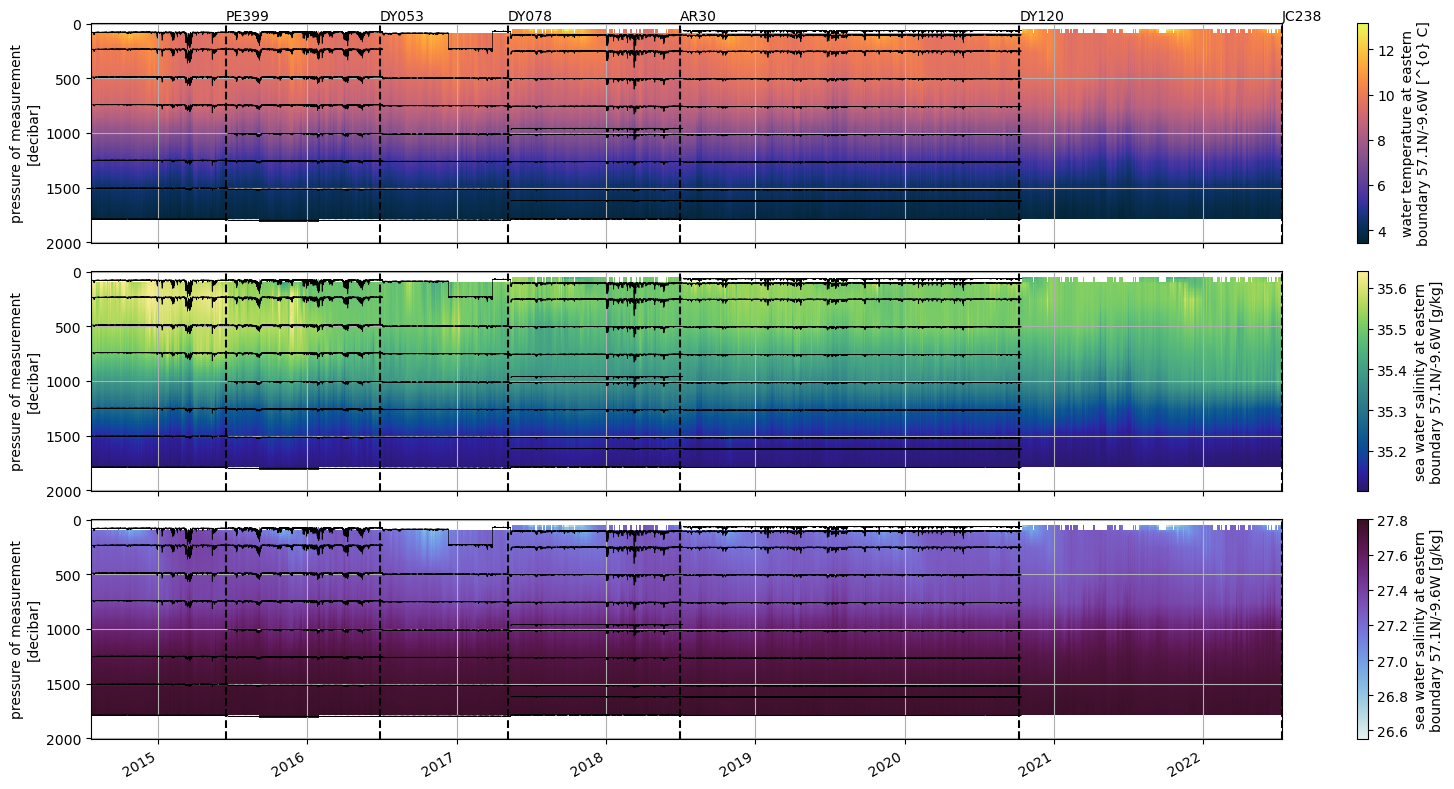

In [12]:
plot_moored_obs(ds_RT,'EB1','hydrography',ds_EB1.PRES)
plot_moored_obs(ds_RT,'EB1','velocity',ds_EB1.PRES)

# WB1

In [13]:
plot_moored_obs(ds_RT,'WB1','hydrography',ds_WB1.PRES)
plot_moored_obs(ds_RT,'WB1','velocity',ds_WB1.PRES)

# WB2

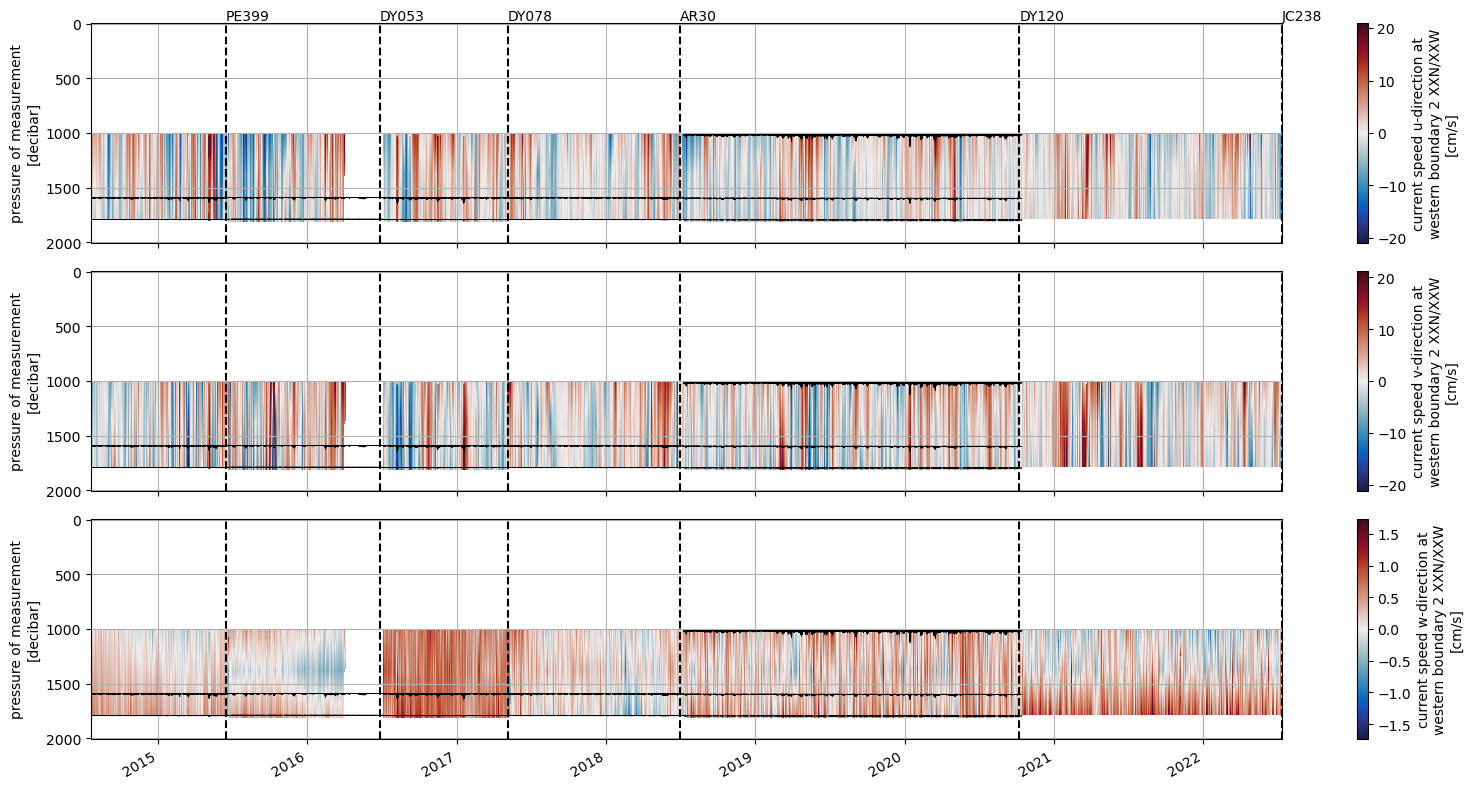

In [14]:
plot_moored_obs(ds_RT,'WB2','velocity',ds_WB2.PRES)

# EB1 corrections
Starting with the upper layer. The 2022 data following the old processein has some differences to the 2020 data. I guess some spikes that where not detected properly. So I will combine the 2022 data and the 2020 data so create a mask for the current data.

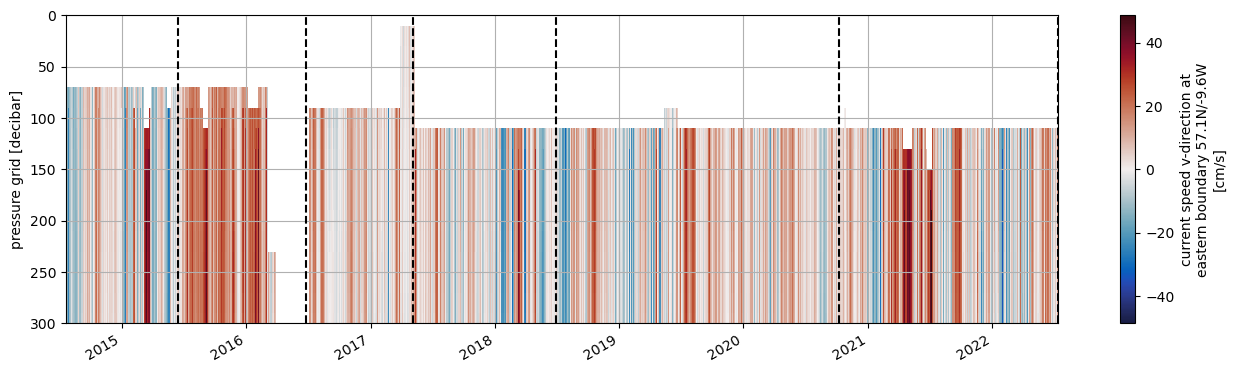

In [15]:
fig,axs = plt.subplots(1,1,figsize=[16,4],sharex=True)
ax = axs
ds_RT.V_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)

# ds_EB1.PRES.plot.line('k',ax=ax,x='TIME',hue='DEPTH',add_legend=False,lw=0.5)
ax.vlines(ds_cruises.TIME,0, 1,transform=ax.get_xaxis_transform(),color='k',linestyle='--')
ax.set_xlabel('')
ax.grid()

for i,text in enumerate(ds_cruises):
    ax.annotate(text.values, xy=(ds_cruises[i].TIME,-5),va='bottom')
    ax.set_ylim([300,0])

## remove suspicious values

In [16]:
# remove suspicous upper values
var = ds_RT.V_EAST
mask_1 = var.where((var.TIME>var.TIME.sel(TIME='2017-01-01',method='nearest'))).sel(PRES=80,method='nearest').notnull()
mask_2 = var.where((var.TIME==var.TIME.where(mask_1))
                 & (var.PRES>=500)).notnull()
mask_3 = var.where((var.TIME==var.TIME.where(mask_1==0)) 
                   & (var.TIME<=var.TIME.sel(TIME='2019-01-01',method='nearest'))
         ).notnull()
mask_4 = var.where((var.TIME>var.TIME.sel(TIME='2019-01-01',method='nearest')) 
                   &(var.PRES>=110)).notnull()
mask = mask_2+mask_3+mask_4

ds_RT['V_EAST'] = ds_RT['V_EAST'].where(mask)
ds_RT['U_EAST'] = ds_RT['U_EAST'].where(mask)
ds_RT['W_EAST'] = ds_RT['W_EAST'].where(mask)

In [17]:
def remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,var):
    ds_RT_old = xr.concat([ds_RT_old20[var].sel(TIME=slice(None,'2020-10-09T12:00:00')),
               ds_RT_old22[var].sel(TIME=slice('2020-10-10T00:00:00',None))],
              dim='TIME')
    var = ds_RT[var]
    mask = ds_RT_old-var==0 #cm
    var = var.where(mask)
    return var

ds_RT['V_EAST'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'V_EAST')
ds_RT['U_EAST'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'U_EAST')
ds_RT['W_EAST'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'W_EAST')

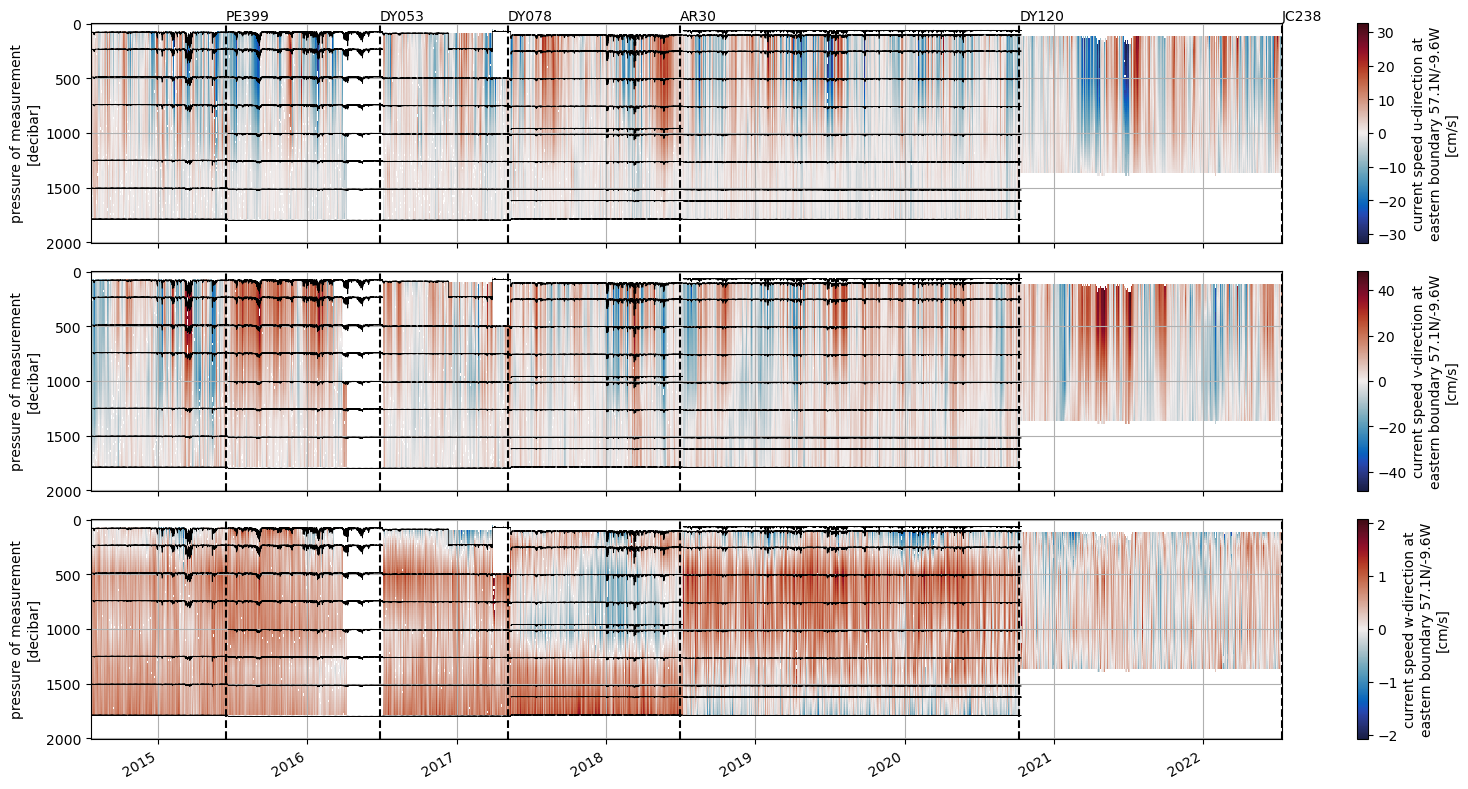

In [18]:
plot_moored_obs(ds_RT,'EB1','velocity',ds_EB1.PRES)

## linear interpolation of upper values

In [19]:
def linear_upper_values_EAST(var):
    var_i = var.interpolate_na(
        dim='PRES',
        method="linear",
    )
    tlim = var_i.TIME.sel(TIME='2020-10-09T12:00:00',method='nearest')
    mask_2 = var_i.where((var_i.TIME>tlim)).notnull()
    mask_2 = mask_2 + var_i.where((var_i.TIME>tlim)).shift(PRES=-12).notnull()
    var_i = var.interpolate_na(
        dim='PRES',
        method="linear",
        fill_value="extrapolate",
    )
    mask_1 = var_i.where((var_i.PRES<=1780)&(var.TIME<=tlim)).notnull()
    mask = mask_1+mask_2

    var_i = var_i.where(mask)
    return var_i


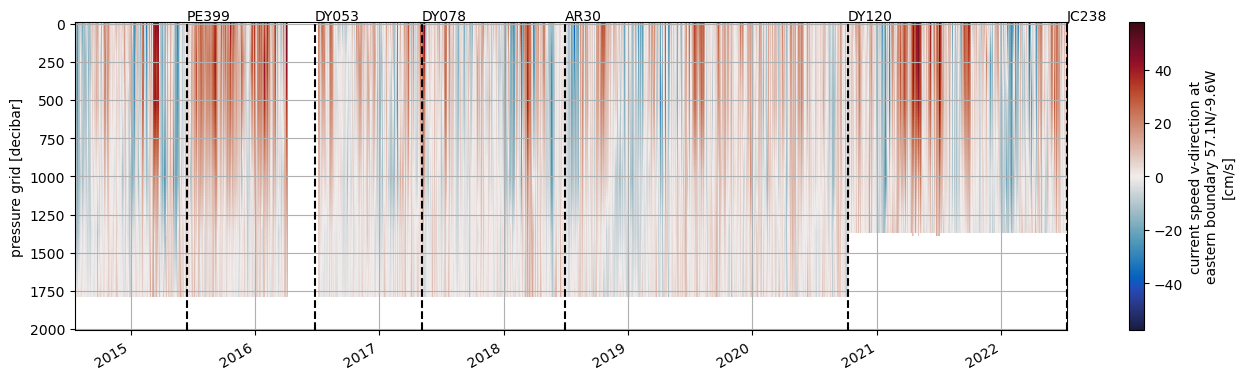

In [20]:
ds_RT['V_EAST'] = linear_upper_values_EAST(ds_RT.V_EAST)
ds_RT['U_EAST'] = linear_upper_values_EAST(ds_RT.U_EAST)
ds_RT['W_EAST'] = linear_upper_values_EAST(ds_RT.W_EAST)

V_EAST = ds_RT['V_EAST']

fig,axs = plt.subplots(1,1,figsize=[16,4],sharex=True)
ax = axs
(V_EAST).plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)

# ds_EB1.PRES.plot.line('k',ax=ax,x='TIME',hue='DEPTH',add_legend=False,lw=0.5)
ax.vlines(ds_cruises.TIME,0, 1,transform=ax.get_xaxis_transform(),color='k',linestyle='--')
ax.set_xlabel('')
ax.grid()

for i,text in enumerate(ds_cruises):
    ax.annotate(text.values, xy=(ds_cruises[i].TIME,-5),va='bottom')

## extrapolation of 1350m values for 2021-2022 period

In [21]:
def nearest_lower_values_EAST(var):
    var_i = var.interpolate_na(
            dim='PRES',
            method="nearest",
            fill_value="extrapolate",
        ).where((var.PRES<=1780))
    return var_i

ds_RT['V_EAST'] = nearest_lower_values_EAST(ds_RT.V_EAST)
ds_RT['U_EAST'] = nearest_lower_values_EAST(ds_RT.U_EAST)
ds_RT['W_EAST'] = nearest_lower_values_EAST(ds_RT.W_EAST)

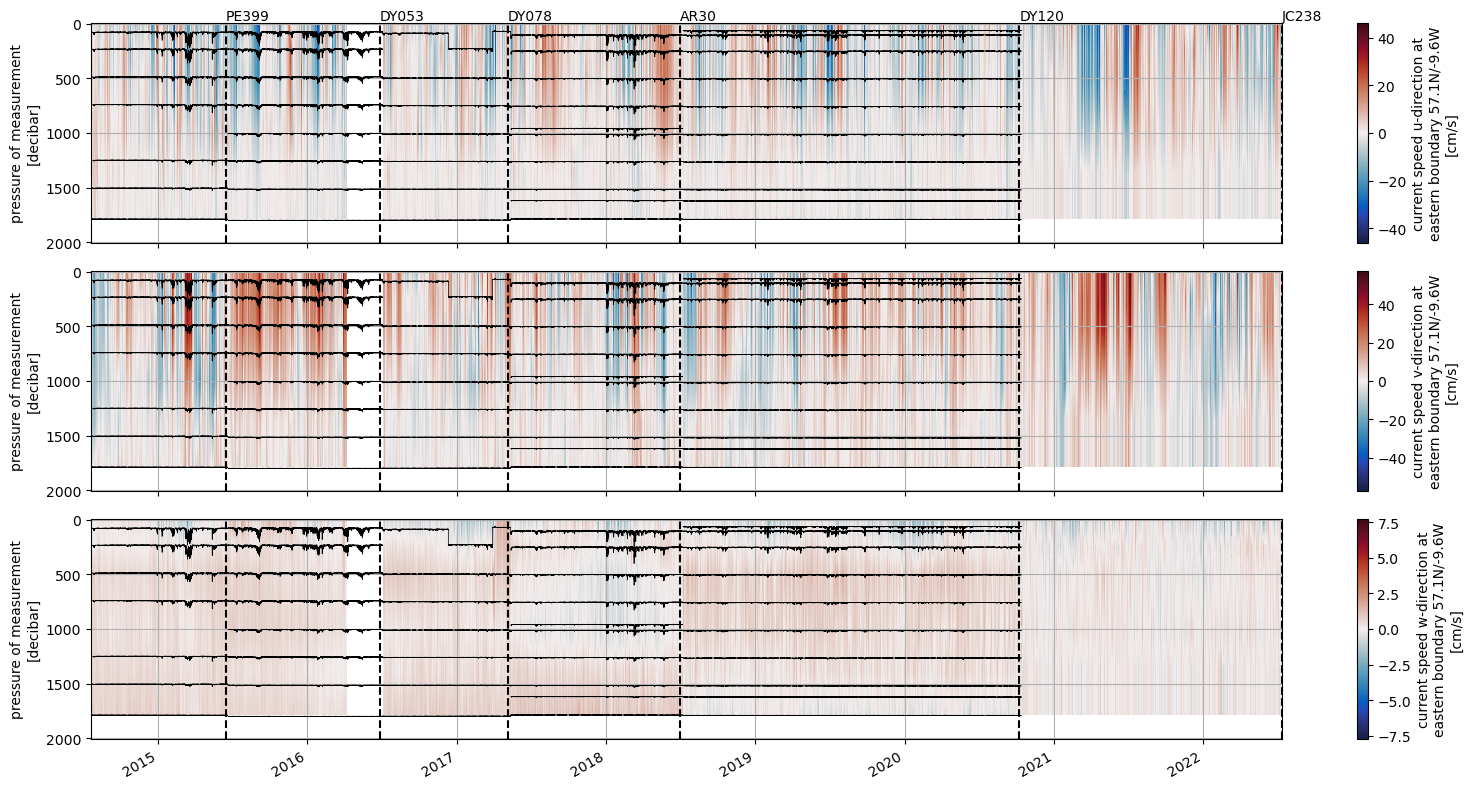

In [22]:
plot_moored_obs(ds_RT,'EB1','velocity',ds_EB1.PRES)

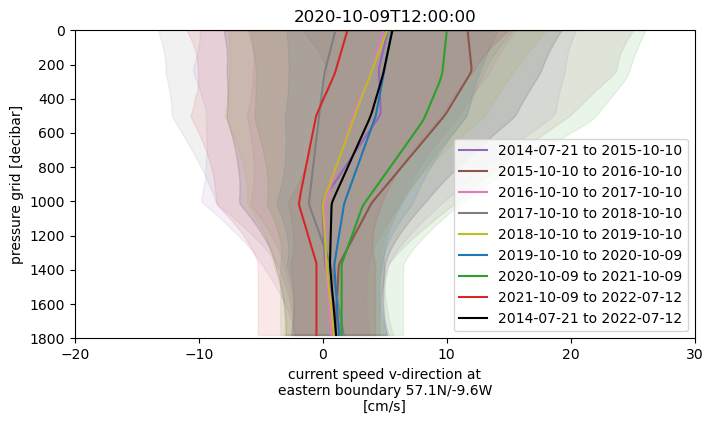

In [23]:
t='2020-10-09T12:00:00'
t1='2019-10-10T00:00:00'
t2='2021-10-09T00:00:00'
t3='2018-10-10T00:00:00'
t4='2017-10-10T00:00:00'
t5='2016-10-10T00:00:00'
t6='2015-10-10T00:00:00'

fig, ax = plt.subplots(figsize=(8, 4))
var = ds_RT['V_EAST']

dummy = var.sel(TIME=slice(None,t6)).mean('TIME',keep_attrs=True)
dummy2 = var.sel(TIME=slice(None,t6)).std('TIME',keep_attrs=True)
dummy.plot.line('C4',y='PRES',ax=ax,label=f'{var.TIME.min().values:.10s} to {t6:.10s}')
ax.fill_betweenx(dummy.PRES, dummy - dummy2, dummy + dummy2, color='C4', alpha=0.1)

dummy = var.sel(TIME=slice(t6,t5)).mean('TIME',keep_attrs=True)
dummy2 = var.sel(TIME=slice(t6,t5)).std('TIME',keep_attrs=True)
dummy.plot.line('C5',y='PRES',ax=ax,label=f'{t6:.10s} to {t5:.10s}')
ax.fill_betweenx(dummy.PRES, dummy - dummy2, dummy + dummy2, color='C5', alpha=0.1)

dummy = var.sel(TIME=slice(t5,t4)).mean('TIME',keep_attrs=True)
dummy2 = var.sel(TIME=slice(t5,t4)).std('TIME',keep_attrs=True)
dummy.plot.line('C6',y='PRES',ax=ax,label=f'{t5:.10s} to {t4:.10s}')
ax.fill_betweenx(dummy.PRES, dummy - dummy2, dummy + dummy2, color='C6', alpha=0.1)

dummy = var.sel(TIME=slice(t4,t3)).mean('TIME',keep_attrs=True)
dummy2 = var.sel(TIME=slice(t4,t3)).std('TIME',keep_attrs=True)
dummy.plot.line('C7',y='PRES',ax=ax,label=f'{t4:.10s} to {t3:.10s}')
ax.fill_betweenx(dummy.PRES, dummy - dummy2, dummy + dummy2, color='C7', alpha=0.1)

dummy = var.sel(TIME=slice(t3,t1)).mean('TIME',keep_attrs=True)
dummy2 = var.sel(TIME=slice(t3,t1)).std('TIME',keep_attrs=True)
dummy.plot.line('C8',y='PRES',ax=ax,label=f'{t3:.10s} to {t1:.10s}')
ax.fill_betweenx(dummy.PRES, dummy - dummy2, dummy + dummy2, color='C8', alpha=0.1)

dummy = var.sel(TIME=slice(t1,t)).mean('TIME',keep_attrs=True)
dummy2 = var.sel(TIME=slice(t1,t)).std('TIME',keep_attrs=True)
dummy.plot.line('C0',y='PRES',ax=ax,label=f'{t1:.10s} to {t:.10s}');
ax.fill_betweenx(dummy.PRES, dummy - dummy2, dummy + dummy2, color='C0', alpha=0.1)

dummy = var.sel(TIME=slice(t,t2)).mean('TIME',keep_attrs=True)
dummy2 = var.sel(TIME=slice(t,t2)).std('TIME',keep_attrs=True)
dummy.plot.line('C2',y='PRES',ax=ax,label=f'{t:.10s} to {t2:.10s}')
ax.fill_betweenx(dummy.PRES, dummy - dummy2, dummy + dummy2, color='C2', alpha=0.1)

dummy = var.sel(TIME=slice(t2,None)).mean('TIME',keep_attrs=True)
dummy2 = var.sel(TIME=slice(t2,None)).std('TIME',keep_attrs=True)
dummy.plot.line('C3',y='PRES',ax=ax,label=f'{t2:.10s} to {var.TIME.max().values:.10s}')
ax.fill_betweenx(dummy.PRES, dummy - dummy2, dummy + dummy2, color='C3', alpha=0.1)

dummy = var.mean('TIME',keep_attrs=True)
dummy2 = var.std('TIME',keep_attrs=True)
dummy.plot.line('k',y='PRES',ax=ax,label=f'{var.TIME.min().values:.10s} to {var.TIME.max().values:.10s}')
ax.fill_betweenx(dummy.PRES, dummy - dummy2, dummy + dummy2, color='k', alpha=0.1)

plt.title(t);
plt.ylim([1800,0]);
plt.xlim([-20, 30]);
plt.legend()

In [24]:
t='2015-4'
ds_RT.V_EAST.sel(TIME=t).plot(y='PRES',hue='TIME',ylim=[1800,1300],add_legend=False,lw=0.5);
ds_RT.V_EAST.sel(TIME=t).mean('TIME',keep_attrs=True).plot.line('k',y='PRES',ylim=[1800,1300],add_legend=False)
plt.axhline(1350,color='k',lw=0.8,ls='--')
plt.axhline(1780,color='k',lw=0.8,ls='--')
plt.title(t);

# remove spurious values and upper extraploation hygrography

In [25]:
def repeat_upper_values(var):
    mask = var.notnull()
    mask = mask + var.shift(PRES=-10).notnull()
    var = var.interpolate_na(
        dim='PRES',
        method="nearest",
        fill_value="extrapolate",
    ).where(mask)
    return var

In [26]:
ds_RT['TG_EAST'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'TG_EAST')
ds_RT['SG_EAST'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'SG_EAST')
ds_RT['TG_EAST'] = ds_RT['TG_EAST'].interpolate_na(dim='PRES',method='linear')
ds_RT['SG_EAST'] = ds_RT['SG_EAST'].interpolate_na(dim='PRES',method='linear')
ds_RT['TG_EAST'] = repeat_upper_values(ds_RT['TG_EAST'])
ds_RT['SG_EAST'] = repeat_upper_values(ds_RT['SG_EAST'])


In [27]:
plot_moored_obs(ds_RT,'EB1','hydrography',ds_EB1.PRES)

# WB1

# remove spurious values and upper extraploation hygrography

In [28]:
ds_RT['TG_WEST'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'TG_WEST')
ds_RT['SG_WEST'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'SG_WEST')

ds_RT['TG_WEST'] = ds_RT['TG_WEST'].interpolate_na(dim='PRES',method='linear')
ds_RT['SG_WEST'] = ds_RT['SG_WEST'].interpolate_na(dim='PRES',method='linear')
ds_RT['TG_WEST'] = repeat_upper_values(ds_RT['TG_WEST'])
ds_RT['SG_WEST'] = repeat_upper_values(ds_RT['SG_WEST'])

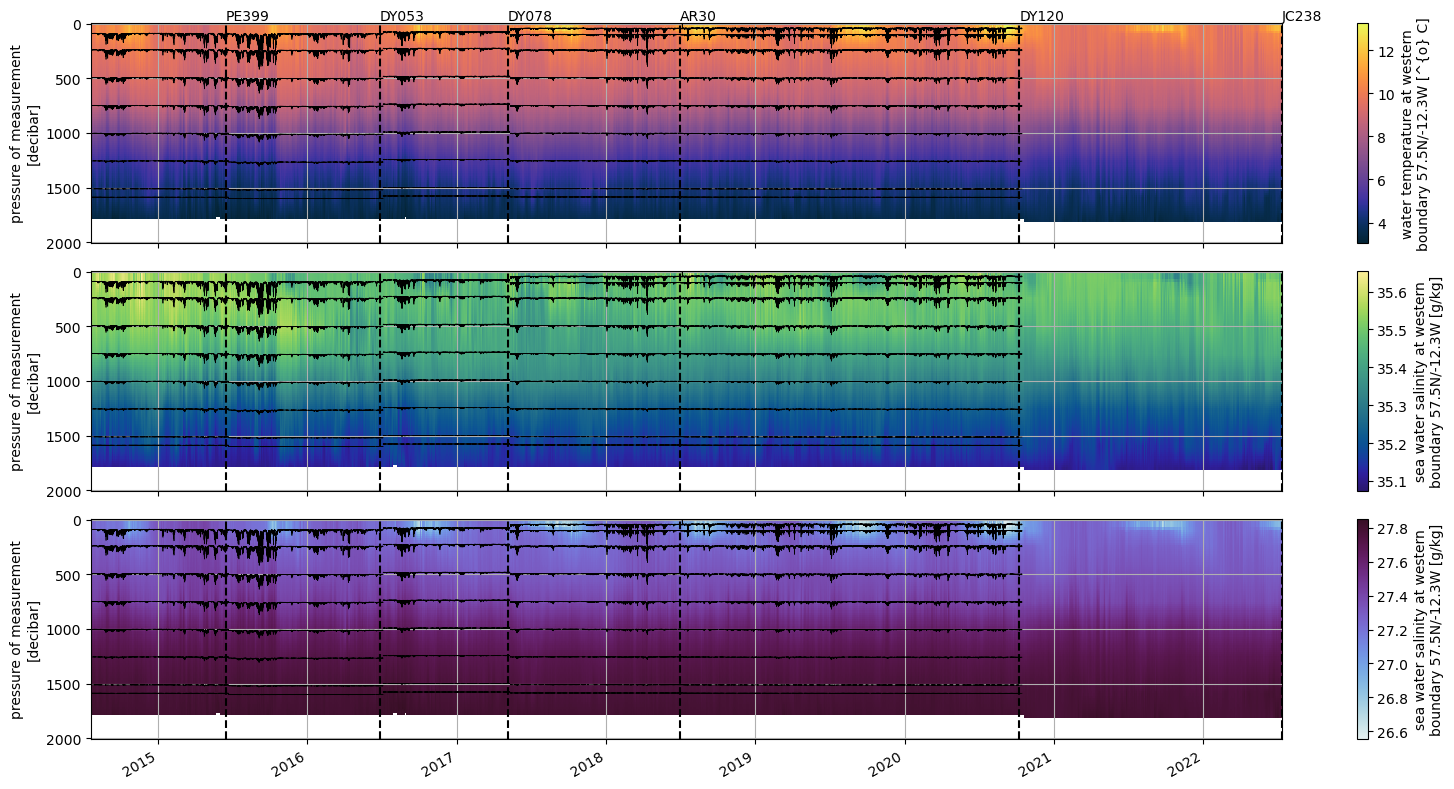

In [29]:
plot_moored_obs(ds_RT,'WB1','hydrography',ds_WB1.PRES)

# remove spurious values and upper extraploation velocity

In [30]:
ds_RT['V_WEST_1'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'V_WEST_1')
ds_RT['U_WEST_1'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'U_WEST_1')
ds_RT['W_WEST_1'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'W_WEST_1')

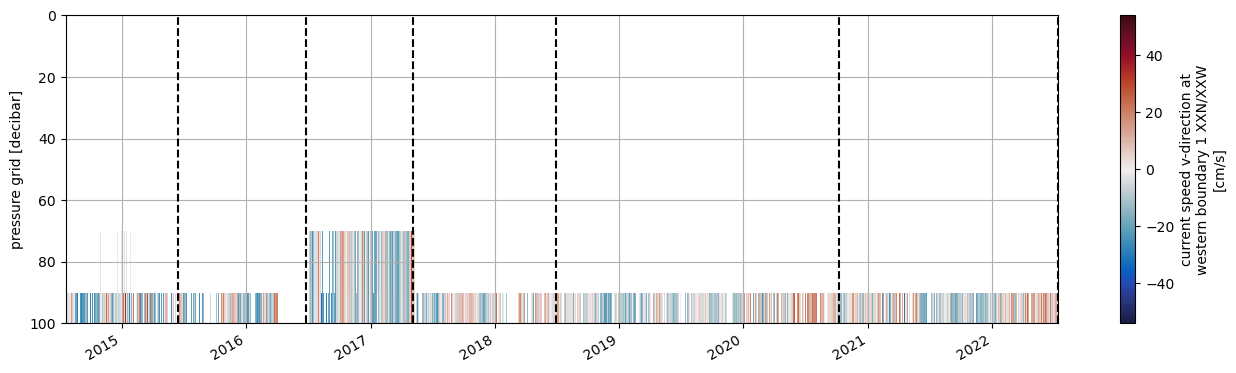

In [31]:
V_EAST = ds_RT['V_WEST_1']

fig,axs = plt.subplots(1,1,figsize=[16,4],sharex=True)
ax = axs
(V_EAST).plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)

# ds_EB1.PRES.plot.line('k',ax=ax,x='TIME',hue='DEPTH',add_legend=False,lw=0.5)
ax.vlines(ds_cruises.TIME,0, 1,transform=ax.get_xaxis_transform(),color='k',linestyle='--')
ax.set_xlabel('')
ax.grid()

for i,text in enumerate(ds_cruises):
    ax.annotate(text.values, xy=(ds_cruises[i].TIME,-5),va='bottom')

ax.set_ylim([100,0]);

In [32]:
# remove suspicous upper values
var = ds_RT.V_WEST_1
mask_2 = var.where((var.TIME<=var.TIME.sel(TIME='2016-01-01',method='nearest'))
                   &(var.PRES>=100)
         ).notnull()
mask_3 = var.where((var.TIME>var.TIME.sel(TIME='2016-01-01',method='nearest')) 
                   ).notnull()
mask=mask_2+mask_3
ds_RT['V_WEST_1'] = ds_RT['V_WEST_1'].where(mask)
ds_RT['U_WEST_1'] = ds_RT['U_WEST_1'].where(mask)
ds_RT['W_WEST_1'] = ds_RT['W_WEST_1'].where(mask)

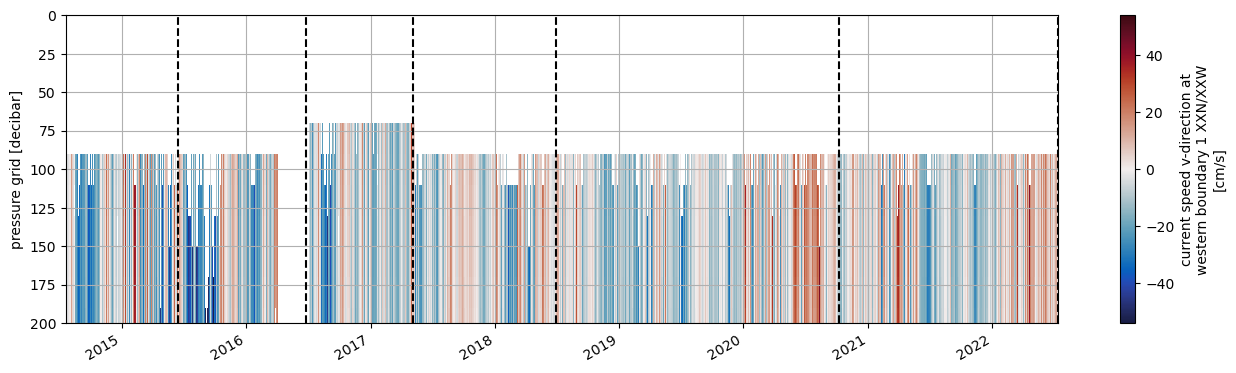

In [33]:
V_EAST = ds_RT['V_WEST_1']

fig,axs = plt.subplots(1,1,figsize=[16,4],sharex=True)
ax = axs
(V_EAST).plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)

# ds_EB1.PRES.plot.line('k',ax=ax,x='TIME',hue='DEPTH',add_legend=False,lw=0.5)
ax.vlines(ds_cruises.TIME,0, 1,transform=ax.get_xaxis_transform(),color='k',linestyle='--')
ax.set_xlabel('')
ax.grid()

for i,text in enumerate(ds_cruises):
    ax.annotate(text.values, xy=(ds_cruises[i].TIME,-5),va='bottom')

ax.set_ylim([200,0]);

## linear extrapolation to surface

In [34]:
def linear_upper_values_WEST(var):
    var_i = var.interpolate_na(
        dim='PRES',
        method="linear",
        fill_value="extrapolate",
    )
    mask = var_i.where((var_i.PRES<=1580)).notnull()

    var_i = var_i.where(mask)
    return var_i

ds_RT['V_WEST_1'] = linear_upper_values_WEST(ds_RT['V_WEST_1'])
ds_RT['U_WEST_1'] = linear_upper_values_WEST(ds_RT['U_WEST_1'])
ds_RT['W_WEST_1'] = linear_upper_values_WEST(ds_RT['W_WEST_1'])

In [ ]:
plot_moored_obs(ds_RT,'WB1','velocity',ds_WB1.PRES)

# WB2
## remove suspicious velocities and linearly inter/extrapolate

In [ ]:
ds_RT['V_WEST_2'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'V_WEST_2')
ds_RT['U_WEST_2'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'U_WEST_2')
ds_RT['W_WEST_2'] = remove_susp_values(ds_RT,ds_RT_old20,ds_RT_old22,'W_WEST_2')

ds_RT['V_WEST_2'] = ds_RT['V_WEST_2'].interpolate_na(dim='PRES',method='linear',fill_value='extrapolate')
ds_RT['U_WEST_2'] = ds_RT['U_WEST_2'].interpolate_na(dim='PRES',method='linear',fill_value='extrapolate')
ds_RT['W_WEST_2'] = ds_RT['W_WEST_2'].interpolate_na(dim='PRES',method='linear',fill_value='extrapolate')

mask = (ds_RT.PRES<1800)&(ds_RT.PRES>1020)

ds_RT['V_WEST_2'] = ds_RT['V_WEST_2'].where(mask)
ds_RT['U_WEST_2'] = ds_RT['U_WEST_2'].where(mask)
ds_RT['W_WEST_2'] = ds_RT['W_WEST_2'].where(mask)

In [ ]:
plot_moored_obs(ds_RT,'WB2','velocity',ds_WB2.PRES)

# plot again all data

In [ ]:
plot_moored_obs(ds_RT,'EB1','hydrography',ds_EB1.PRES)
plot_moored_obs(ds_RT,'EB1','velocity',ds_EB1.PRES)

plot_moored_obs(ds_RT,'WB1','hydrography',ds_WB1.PRES)
plot_moored_obs(ds_RT,'WB1','velocity',ds_WB1.PRES)

plot_moored_obs(ds_RT,'WB2','velocity',ds_WB2.PRES)

In [ ]:
ds_RT.attrs['title']='CLASS Rockall Trough mooring data Jul 2014 to Jul 2022'
ds_RT.attrs['history']=f'Delayed time processed quality controlled Surface extrapolation done with. Surface extrapolation done with {script_name}.ipynb'
ds_RT.attrs['id']='Rockall_Trough_mooring_gridded_TSUV_201407_202207_v0.1'
ds_RT.attrs['time_coverage_start'] = f'{ds_RT.TIME.min().values}'
ds_RT.attrs['time_coverage_end'] = f'{ds_RT.TIME.max().values}'
ds_RT.attrs['date_modified'] = datetime.datetime.now().strftime("%d-%m-%YT%H:%M:%SZ")
ds_RT.attrs['contributor_name'] = 'Kristin Burmeister'
ds_RT.attrs['contributor_email'] = 'Kristin.Burmeister@sams.ac.uk'
ds_RT.to_netcdf((data_out_path+file_name_out))

In [ ]:
xr.open_dataset((data_out_path+file_name_out))